## Imports

In [82]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 159, in _get_module_details
  File "<frozen importlib._bootstrap_external>", line 1073, in get_code
  File "<frozen importlib._bootstrap_external>", line 1131, in get_data
OSError: [Errno 22] Invalid argument


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import re
import string
import numpy as np
import pickle
from IPython.display import display
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import os
import warnings

# downloading
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as m
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def NBtrain(X_TRAIN,Y_TRAIN):
  clf1 = GaussianNB()
  clf2 = MultinomialNB()
  clf3 = BernoulliNB()
  clf1.fit(X_TRAIN,Y_TRAIN)
  y_pred1_train = clf1.predict(X_TRAIN)
    
  clf2.fit(X_TRAIN,Y_TRAIN)
  y_pred2_train = clf2.predict(X_TRAIN)
 
  clf3.fit(X_TRAIN,Y_TRAIN)
  y_pred3_train = clf3.predict(X_TRAIN)
  return (clf1,clf2,clf3)

def NBtest(clf1,clf2,clf3,X_TEST,Y_TEST=[]):
  warnings.filterwarnings('ignore')
  y_pred1_test = clf1.predict(X_TEST)
  y_pred2_test = clf2.predict(X_TEST)
  y_pred3_test = clf3.predict(X_TEST)
  if(len(Y_TEST) != 0):
    print("-----\n")
    print("The test accuracy accuracy for GaussianNB ",m.accuracy_score(Y_TEST,y_pred1_test))
    print("Classification report ---> GaussianNB <---- \n",m.classification_report(Y_TEST,y_pred1_test))

    print("-----\n")
    print("The test accuracy accuracy for MultinomialNB ",m.accuracy_score(Y_TEST,y_pred2_test))
    print("Classification report ---> MultinomialNB <---- \n",m.classification_report(Y_TEST,y_pred2_test))

    print("-----\n")
    print("The test accuracy accuracy for BernoulliNB ",m.accuracy_score(Y_TEST,y_pred3_test))
    print("Classification report ---> BernoulliNB <----\n",m.classification_report(Y_TEST,y_pred3_test))

  return y_pred1_test,y_pred2_test,y_pred3_test

In [6]:
def RFtrain(X_TRAIN,Y_TRAIN):
  # Hyperparameter Tuning
  rfc=RandomForestClassifier()
  params={'n_estimators':[50,100,150,200],
        'criterion':['gini','entropy'],
        "max_depth":[2,4,8,10],
        "min_samples_leaf":[2,4,7,10]}
  gs=GridSearchCV(rfc,param_grid=params,cv=10,n_jobs=-1,return_train_score=True)
  model = gs.fit(X_TRAIN,Y_TRAIN)
  cf=pd.DataFrame(gs.cv_results_)
  print("The best estimator ",gs.best_estimator_)
  print("Best paramters ",gs.best_params_)
  rfc=RandomForestClassifier(**gs.best_params_)
  rfc.fit(X_TRAIN,Y_TRAIN)
  y_pred1_train = rfc.predict(X_TRAIN)
  return model


def RFtest(rfc,X_TEST,Y_TEST=[]):
  y_pred_test = rfc.predict(X_TEST)
  if(len(Y_TEST) != 0):
    print("-----\n")
    print("The test accuracy accuracy for Random Forest ",m.accuracy_score(Y_TEST,y_pred_test))
    print("Classification report ---> Random Forest <---- \n",m.classification_report(Y_TEST,y_pred_test))

  return y_pred_test

In [7]:
def Dtrain(X_train,Y_TRAIN):
  DT_model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 41, min_samples_split = 112)
  DT_model.fit(X_train,Y_TRAIN)
  return DT_model

def Dtest(DT_model,X_test,Y_TEST = []):
  Y_pred  = DT_model.predict(X_test)
  if(len(Y_TEST) != 0):
    results = confusion_matrix(Y_TEST, Y_pred)
    print("-----\n")
    print("The test accuracy accuracy for Decision  Tree ",m.accuracy_score(Y_TEST,Y_pred))
    print("Classification report ---> Decision  Tree <---- \n",m.classification_report(Y_TEST,Y_pred))

  return Y_pred

In [8]:
def Ktrain(X_train,Y_TRAIN):
  KNN_model = KNeighborsClassifier(n_neighbors=48,metric = "manhattan",p=1)
  KNN_model.fit(X_train, Y_TRAIN)
  return KNN_model

def Ktest(KNN_model,X_test,Y_TEST = []):
  Y_pred = KNN_model.predict(X_test)
  if(len(Y_TEST) != 0):
    results = confusion_matrix(Y_TEST, Y_pred)
    print("-----\n")
    print("The test accuracy accuracy for KNN ",m.accuracy_score(Y_TEST,Y_pred))
    print("Classification report ---> K Nearest Neighbour <---- \n",m.classification_report(Y_TEST,Y_pred))
  return Y_pred

## Setting up modifier and text preprocessing functions

[RUN FOR TESTING]

In [9]:
# variable declarations
maxlen=24

replace_collocations = {
    "aren't": "are not",
    "can't": "cannot",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "here's": "here is",
    "isn't": "is not",
    "it's": "it is",
    "i'm": "i am",
    "i've": "i have",
    "it'll": "it will",
    "it'd": "it would",
    "i'd": "i would",
    "i'll": "i will",
    "mightn't": "might not",
    "mustn't": "must not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "there's": "there has",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "weren't": "were not",
    "won't": "will not",
    "wouldn't": "would not",
    "what's": "what is",
    "you're": "you are",
    "you'll": "you will",
    "you'd": "you would"
}

replace_collocations_with_errors={}
for word, changed_word in replace_collocations.items():
    replace_collocations_with_errors[word.replace("'","")]=changed_word

replace_abbreviations = {
    "ave": "avenue",
    "hwy": "highway",
    "intl": "international",
    "st": "saint",
    "u": "you",
    "stats": "statistics",
    "pkwy": "parkway",
    "av": "autonomous vehicle",
    "conf": "confirm",
    "rd": "road",
    "dr": "doctor",
    "wtf": "what the fuck",
    "mf": "motherfucker",
    "omg": "oh my god",
    "rip": "rest in peace",
    "esp": "especially",
    "ok": "okay",
    "ny": "new york",
    "bc": "because",
    "bcz": "because",
    "sr": "senior",
    "vs": "versus",
    "wht": "what",
    "us'g": "using",
    "s3x": "sex",
    "rn": "right now",

}

replace_word_symbols = {
    "&amp": "&",
    "&gt": ">",
    "ÛÒ": "",
    "åÊ": "",
    "Û÷": "",
    "ÛÓ": "",
    "Û_": "",
    "Û": "",
    "å£": "",
    "å": "",
    "á": "",
    "å": "",
    "á": "",
    "å": "",
    "á": "",
    "Ì": "",
    "¢": "",
    "Û¼": "",
    "&lt": "<",
    "ÛÏ": "",
    "Û": "",
}

In [10]:
def cleaner_func(text):
  '''
  apply the following transformations:
  1. to lowercase
  2. replace wrong symbols
  3. html links
  4. email ids
  5. emoticons
  6. dates
  7. usernames
  8. ip addresses
  9. symbols
  10. replace words with full forms
  11. newlines
  12. double/extra spaces
  text: string on which we need to apply the changes
  '''
  #changing all characters to lowercase
  text=str.lower(text)

  #remove some necessary text ASCII characters
  for val,re_val in replace_word_symbols.items():
    text=re.sub(val,re_val,text)

  #remove html links (also includes: http://www.amazon.co.jp/エレクトロニクス-デジタルカメラ-ポータブルオーディオ/b/ref=topnav_storetab_e?ie=UTF8&node=3210981)
  no_html=r'http[s]?://(?:[\w]|[0-9]|[$-_@.&+]|[!*(),]|(?:%[0-9\w][0-9\w]))+'

  #remove e-mail ids (https://stackoverflow.com/questions/2049502/what-characters-are-allowed-in-an-email-address): (also includes: mason@日本.com)
  no_emails=r"[\w0-9!#$%.(),:;<>@[\]&'\"*+-/=?^_`{|}~]+@[\w0-9_]+\.[\w0-9]+"

  #remove emoticons
  no_emoticons='[\U00010000-\U0010ffff]'
    
  #remove dates
  no_dates='\b(0[1-9]|1[0-2])[-/](0[1-9]|[12]\d|3[01])[-/](\d\d)\b'

  #removing entire profile names as otherwise the profiles will be used for classification as well!! (twitter does not want to!!)
  no_names='@[\w]+'

  #remove ip addresses
  no_ip='d{1,3}.d{1,3}.d{1,3}.d{1,3}'

  #substitute
  lists_of_changes=[no_html, no_emails, no_emoticons, no_dates, no_names, no_ip]
  for val in lists_of_changes:
    text=re.sub(val,'',text)

  #replacements
  replacement_changes=[replace_collocations, replace_abbreviations, replace_collocations_with_errors]
  for change_type in replacement_changes:
    for txt,re_txt in change_type.items():
      text=re.sub(r"\b"+txt+r"\b",re_txt,text)

  #removing all punctuation marks and symbols
  no_symbols='[^a-zA-Z0-9 \n]'
  text=re.sub(no_symbols,'',text)

  #replace nextlines by a space
  text=re.sub('[\n]+',' ',text)

  #replace double or more spaces with a single space
  text=re.sub('[ ]{2,}',' ',text)

  return text
     

In [11]:
def generate_word_cloud(text, save_path, title):
  '''
  generate a wordcloud for the provided data.
  text        :list/array of strings
  save_path   :the location to store the image in
  title       :the name of the image as well as the title
  '''
  vectorizer=CountVectorizer()
  X=vectorizer.fit_transform(text)
  words=vectorizer.get_feature_names_out()
  word_counts=X.sum(axis=0).A1 #get the column sum of each word and then flatten it into a row array
  word_freq = dict(zip(words, word_counts))

  # generate word cloud
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

  # display wordcloud
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(title)
  plt.savefig(os.path.join(save_path, title), bbox_inches='tight', pad_inches=0)
  plt.show()

In [12]:
def transform_text(text):
  punc = list(string.punctuation)
  stop_word = stopwords.words("english")
  Lemmatize = WordNetLemmatizer()

  new_text = " ".join([Lemmatize.lemmatize(word) for word in word_tokenize(text) if ((word not in punc) and (word not in stop_word))])

  return new_text
     

In [32]:
def preprocess(df, is_train=False):
  '''
  Preprocess the data, for both train and test data, as and when accordingly sent
  Display train wordclouds only, not for test
  '''
  global maxlen

  if is_train == True:
    Y_Train=df['target']

  #dropping some unnecessary columns
  dropped_df=df.drop(['id','keyword','location'],axis=1)
  dropped_df

  if is_train == True:
    generate_word_cloud(dropped_df['text'],r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\word cloud','WordCloud before cleaning')

  #apply changes
  changed_df=dropped_df
  changed_df['text']=dropped_df['text'].apply(cleaner_func)
  if is_train == True:
    generate_word_cloud(changed_df['text'],r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\word cloud','WordCloud after cleaning')

  #apply lemmatization and stopword removal
  lemme_df=changed_df
  lemme_df['text']=changed_df['text'].apply(transform_text)

  if is_train == True:
    generate_word_cloud(lemme_df['text'],r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\word cloud','WordCloud after lemmatization and stopword removal')
    generate_word_cloud([e for i, e in enumerate(lemme_df['text']) if Y_Train[i] == 1],r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\word cloud','Word Cloud for Positive Label')
    generate_word_cloud([e for i, e in enumerate(lemme_df['text']) if Y_Train[i] == 0],r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\word cloud','Word Cloud for Negative Label')

  # Tokenization
  tokenizer = Tokenizer(num_words=1000, oov_token="")
  tokenizer.fit_on_texts(lemme_df['text'])
  word_index = tokenizer.word_index

  # Encode training data sentences into sequences
  data_sequences = tokenizer.texts_to_sequences(lemme_df['text'])

  # Get max training sequence length
  if is_train == True:
    maxlen = max([len(x) for x in data_sequences])

  # Padding_Sequences
  data_padding = pad_sequences(data_sequences, padding="pre", truncating="pre", maxlen=maxlen)
  data_padding

  # Conversion into array
  preprocessed_data = np.array(data_padding)

  return preprocessed_data, word_index
     

## Setting up training data

In [33]:
train_df = pd.read_csv('train (3).csv')

In [34]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [35]:
# shuffle the order of rows in the dataset
train_df = train_df.sample(frac=1)

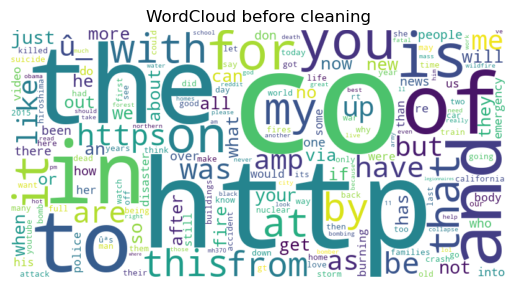

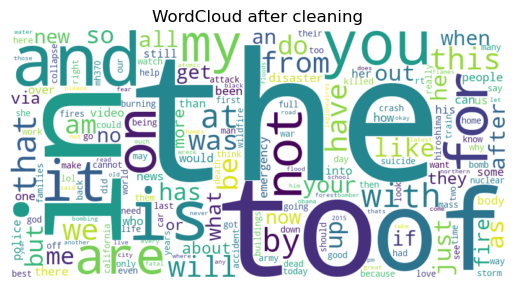

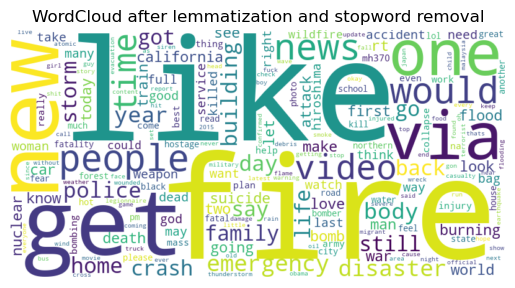

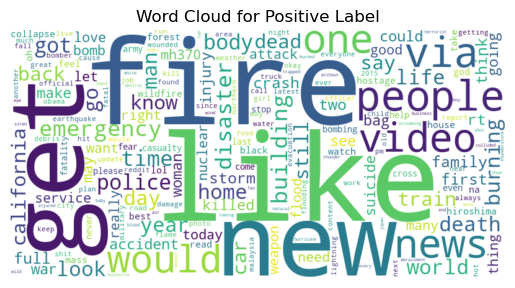

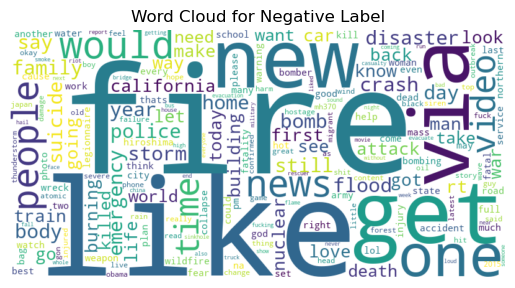

In [40]:
X_Train,wc=preprocess(train_df,True)
Y_Train=np.array(train_df['target'])

In [48]:
print(X_Train)
print(type(X_Train))
print(X_Train.shape)

print(Y_Train)
print(Y_Train.shape)

[[  0   0   0 ...   4  31 798]
 [  0   0   0 ...   1   1 715]
 [  0   0   0 ...   1  89   1]
 ...
 [  0   0   0 ...  12   1   1]
 [  0   0   0 ...  58  16 607]
 [  0   0   0 ...   1  84 439]]
<class 'numpy.ndarray'>
(7613, 24)
[0 0 0 ... 1 1 1]
(7613,)


In [46]:
print(wc)

{'': 1, 'fire': 2, 'like': 3, 'get': 4, 'new': 5, 'via': 6, 'one': 7, 'people': 8, 'news': 9, 'would': 10, 'video': 11, 'time': 12, '2': 13, 'emergency': 14, 'disaster': 15, 'body': 16, 'year': 17, 'police': 18, 'building': 19, 'home': 20, 'day': 21, 'family': 22, 'say': 23, 'still': 24, 'go': 25, 'life': 26, 'got': 27, 'crash': 28, 'storm': 29, 'u': 30, 'back': 31, 'california': 32, 'bomb': 33, 'burning': 34, 'look': 35, 'know': 36, 'suicide': 37, 'world': 38, 'train': 39, 'flood': 40, 'man': 41, 'see': 42, 'death': 43, 'car': 44, 'rt': 45, 'first': 46, 'attack': 47, 'love': 48, '3': 49, 'going': 50, 'nuclear': 51, 'make': 52, 'war': 53, 'today': 54, 'let': 55, 'two': 56, 'accident': 57, 'dead': 58, 'killed': 59, 'want': 60, 'woman': 61, 'need': 62, 'full': 63, 'think': 64, 'good': 65, 'may': 66, 'hiroshima': 67, 'weapon': 68, 'take': 69, 'watch': 70, 'way': 71, 'bag': 72, 'god': 73, 'many': 74, 'last': 75, 'service': 76, 'wildfire': 77, 'right': 78, 'injury': 79, 'could': 80, 'collap

### Insight: There is 14071 unique words in training dataset

## Save the training data in pickle

In [50]:
file_path_X = r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\saved variables\X_data.pickle'
file_path_Y = r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\saved variables\Y_data.pickle'
file_path_XY = r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\saved variables\Actual_data.pickle'

with open(file_path_X, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(X_Train, file)

with open(file_path_Y, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(Y_Train, file)
    
with open(file_path_XY, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(train_df['text'], file)

## Setting the testing data

[ RUN FOR TESTING DATA LIST ]

In [70]:
file_path_X = r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\saved variables\X_data.pickle'
file_path_Y = r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\saved variables\Y_data.pickle'
file_path_XY = r'C:\Users\USER\OneDrive\Pictures\Disaster Tweet Classification\saved variables\Actual_data.pickle'

X_Train=pickle.load(open(file_path_X, 'rb'))
Y_Train=pickle.load(open(file_path_Y, 'rb'))
train_df=pickle.load(open(file_path_XY, 'rb'))

tweet_dict={}
for i in range(len(X_Train)):
  tweet_dict[tuple(X_Train[i])]=train_df[i]

## Everything about the models

[ RUN FOR TESTING ]

In [51]:
path= r'C:\\Users\\USER\\OneDrive\\Pictures\\Disaster Tweet Classification\\saved variables\\'
file1 = path+'finalized_DTree.sav'
file2 = path+'finalized_KNN.sav'
file3 = path+'finalized_RF.sav'
file4 = path+'finalized_GaussianNB.sav'
file5 = path+'finalized_MultinomialNB.sav'
file6 = path+'finalized_BernoulliNB.sav'

### Training dataset

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, Y_Train, test_size=0.2, random_state=42)

In [53]:
modelGaussianNB,modelMultinomialNB,modelBernoulliNB=NBtrain(X_Train,Y_Train)

In [54]:
model_KNN=Ktrain(X_Train, Y_Train)

In [55]:
model_DTree=Dtrain(X_Train, Y_Train)

In [56]:
modelRF=RFtrain(X_Train,Y_Train)

The best estimator  RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=150)
Best paramters  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 150}


## Saving the models

In [57]:
pickle.dump(model_DTree, open(file1, 'wb'))
pickle.dump(model_KNN, open(file2, 'wb'))
pickle.dump(modelRF, open(file3, 'wb'))
pickle.dump(modelGaussianNB, open(file4, 'wb'))
pickle.dump(modelMultinomialNB, open(file5, 'wb'))
pickle.dump(modelBernoulliNB, open(file6, 'wb'))

## Model loading

[ RUN FOR TESTING ]

In [58]:
loaded_model_DTree = pickle.load(open(file1, 'rb'))
loaded_model_KNN = pickle.load(open(file2, 'rb'))
loaded_model_RF = pickle.load(open(file3, 'rb'))
loaded_model_G_NB = pickle.load(open(file4, 'rb'))
loaded_model_M_NB = pickle.load(open(file5, 'rb'))
loaded_model_B_NB = pickle.load(open(file6, 'rb'))

## Choose testing type

[ RUN FOR TESTING ]

### For only one data input

In [66]:
tweet = input('Enter the tweet you want to classify: ')

Xtest = pd.DataFrame([[1,'null','null',tweet,-1]],columns = ['id','keyword','location','text','target'])

Y_test = []

X_test, wc = preprocess(Xtest, Y_test)

Enter the tweet you want to classify:  FLOOD ARRIVED


In [67]:
X_test

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 3]])

In [68]:
X_test.shape

(1, 24)

In [69]:
Y_test

[]

In [70]:
wc

{'': 1, 'flood': 2, 'arrived': 3}

In [71]:
pred_RF = RFtest(loaded_model_RF,X_test,Y_test)

In [72]:
print(pred_RF)

[0]


### For an entire list of data inputs

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, Y_Train, test_size=0.2, random_state=42)     

## Prediction

In [83]:
pred_G_NB,pred_M_NB,pred_B_NB = NBtest(loaded_model_G_NB,loaded_model_M_NB,loaded_model_B_NB,X_test,Y_test)
pred_KNN = Ktest(loaded_model_KNN,X_test,Y_test)
pred_Dtree = Dtest(loaded_model_DTree,X_test,Y_test)
pred_RF = RFtest(loaded_model_RF,X_test,Y_test)

-----

The test accuracy accuracy for GaussianNB  0.4274458305975049
Classification report ---> GaussianNB <---- 
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       873
           1       0.43      1.00      0.60       650

    accuracy                           0.43      1523
   macro avg       0.71      0.50      0.30      1523
weighted avg       0.76      0.43      0.26      1523

-----

The test accuracy accuracy for MultinomialNB  0.5863427445830598
Classification report ---> MultinomialNB <---- 
               precision    recall  f1-score   support

           0       0.65      0.62      0.63       873
           1       0.51      0.55      0.53       650

    accuracy                           0.59      1523
   macro avg       0.58      0.58      0.58      1523
weighted avg       0.59      0.59      0.59      1523

-----

The test accuracy accuracy for BernoulliNB  0.5686145764937623
Classification report ---> BernoulliNB <

In [2]:

X_test, wc = preprocess(train_df[3:1], Y_test)
pred_KNN = Ktest(loaded_model_KNN,X_test,[])
print(pred_KNN)

NameError: name 'preprocess' is not defined